In [52]:
import numpy as np
from coupled_LDS import *
import scipy.stats as stats
import scipy.linalg
from utils import *
import matplotlib.pyplot as plt
from plotting_utils import *
import pymanopt 
import autograd.numpy as anp 
from sippy_unipi import *
from sklearn.linear_model import LinearRegression
import scipy.linalg as sl
import seaborn
seaborn.set_context("talk")
import os

# Standard LDS data generation + testing

In [53]:
S = 1000
max_S = 200
T = 100
D = 50
M = 2
max_iter = 250

In [74]:
K1 = 3
K2 = 3

K = K1 + K2
LDS = coupled_LDS.coupled_LDS(D, K1, K2, M)

In [75]:
param = np.load(f'models/K1={K1}_K2={K2}_true_parameters_and_data_random.npz')
u=param['u']
true_x=param['true_x']
true_y=param['true_y']
true_A=param['true_A']
true_B=param['true_B']
true_Q=param['true_Q']
true_mu0=param['true_mu0']
true_Q0=param['true_Q0']
true_C=param['true_C']
true_d=param['true_d']
true_R=param['true_R']

In [76]:
simulation = 0
fitted = np.load(f'models/K1={K1}_K2={K2}_fitted_param_simulation={simulation}.npz')
ecll_new=fitted['ecll_new']
ecll_old=fitted['ecll_old']
elbo=fitted['elbo']
ll=fitted['ll']
A=fitted['A']
B=fitted['B']
Q=fitted['Q']
mu0=fitted['mu0']
Q0=fitted['Q0']
C=fitted['C']
d=fitted['d']
R=fitted['R']

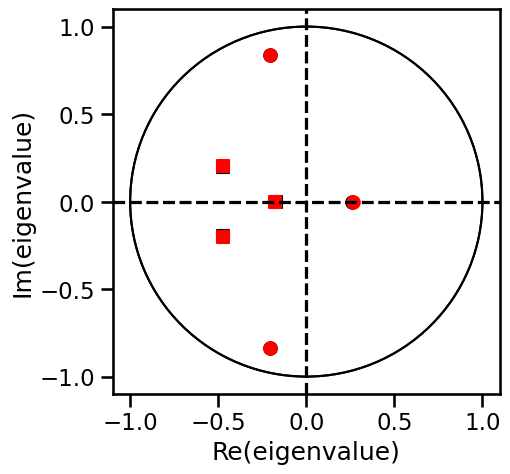

In [77]:
fig, axes = plt.subplots(figsize=(5,5))
plot_eigenvalues(axes, np.linalg.eigvals(A[:K1,:K1]), np.linalg.eigvals(A[K1:,K1:]))
plot_eigenvalues(axes, np.linalg.eigvals(true_A[:K1,:K1]), np.linalg.eigvals(true_A[K1:,K1:]), color='red')

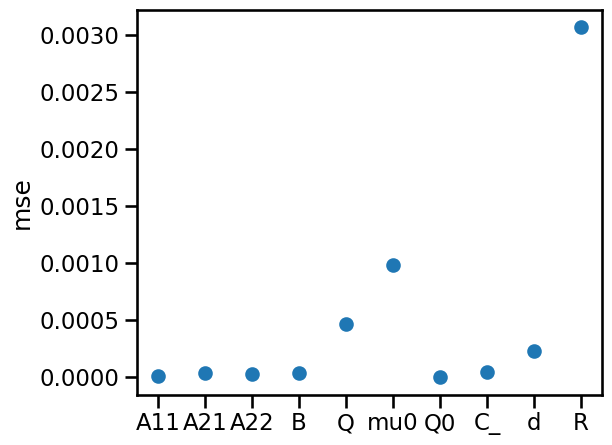

In [78]:
fig, axes = plt.subplots(figsize=(6,5))
plot_mse_parameters(axes, K1, A, B, Q, mu0, true_Q0, C, d, R, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R)

(300,)


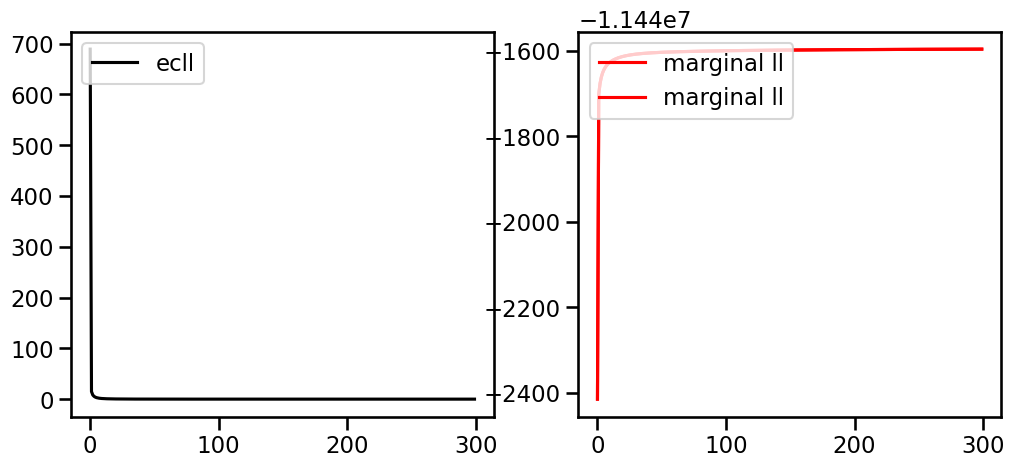

In [79]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
# print(ll.sum(axis=1))
print(ll.sum(axis=1).shape)
axes[0].plot(ecll_new-ecll_old, color='black', label='ecll')
axes[1].plot(elbo, color='red', label='marginal ll')
axes[1].plot(ll.sum(axis=1), color='red', label='marginal ll')
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')

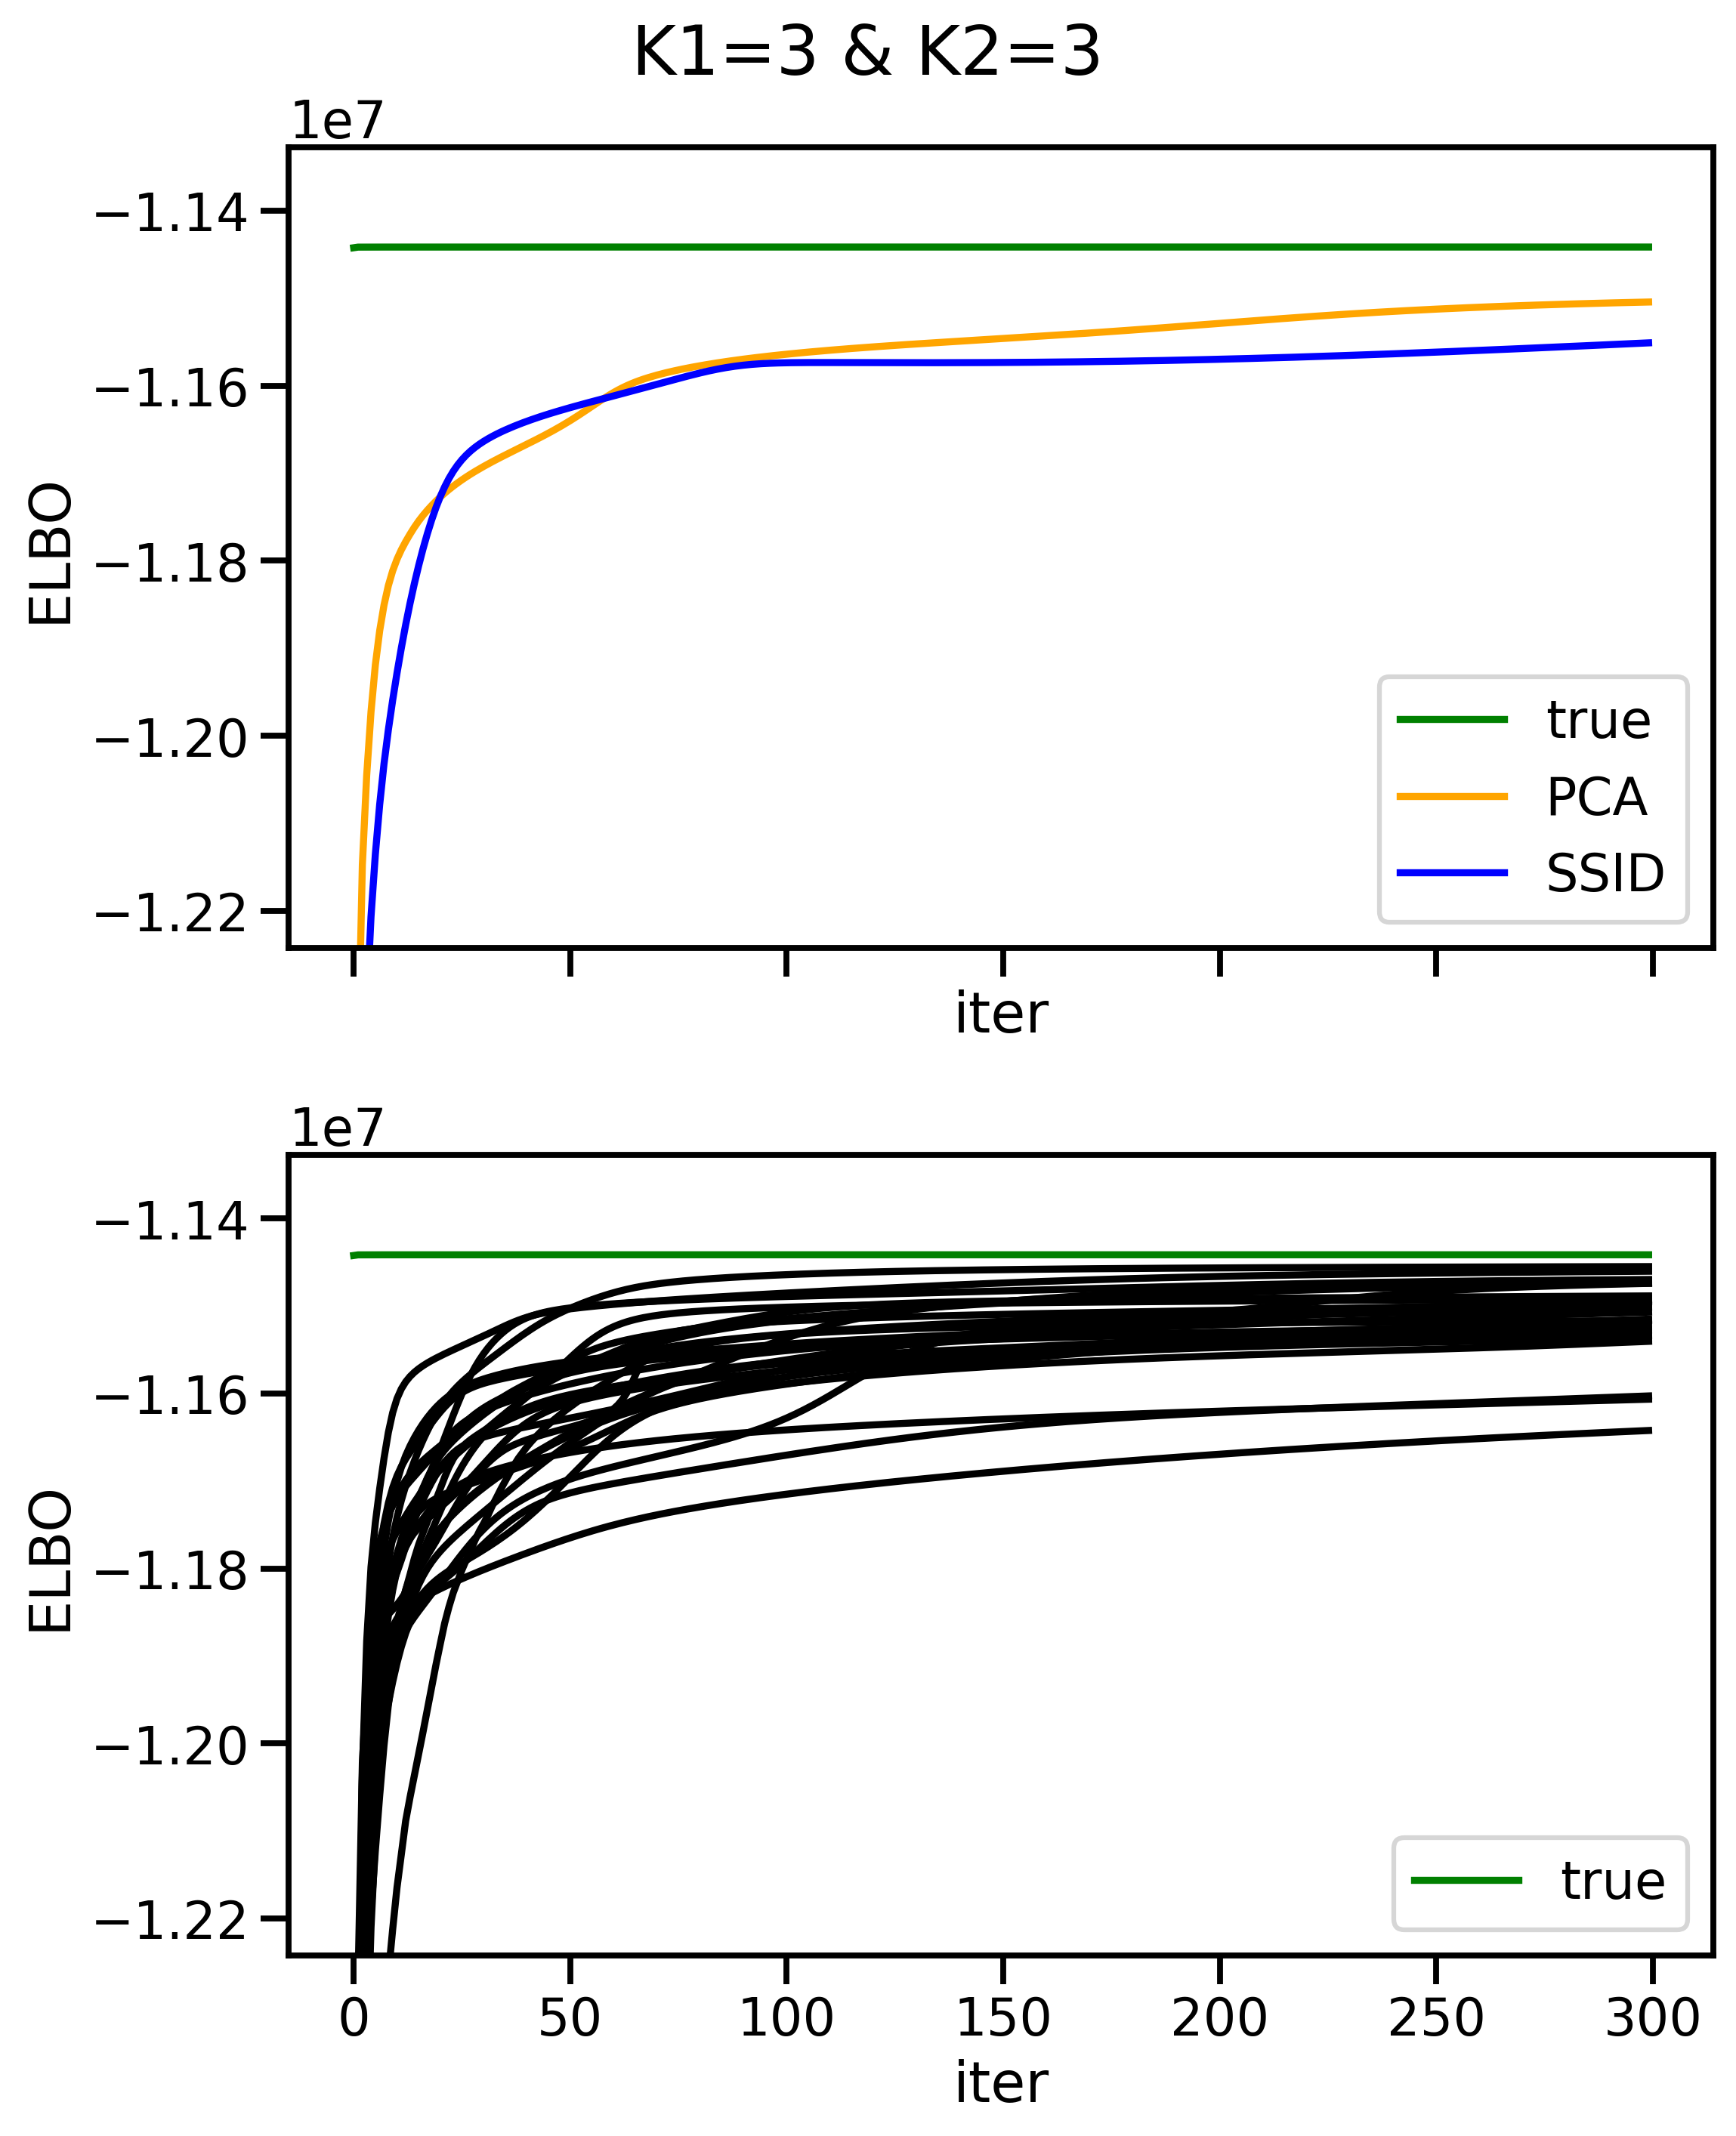

In [80]:
max_iter=300
eps = 0.1
import mpl_toolkits.axes_grid1.inset_locator as inset
fig, axes = plt.subplots(2,1,figsize=(8,10), dpi=300, sharex=True)
color = ['green','orange','blue'] + ['black' for i in range(27)]
label = ['true','PCA','SSID','best random']

elbos = []

for simulation in range(30):
    if os.path.exists(f'models/K1={K1}_K2={K2}_fitted_param_simulation={simulation}.npz'):
        fitted = np.load(f'models/K1={K1}_K2={K2}_fitted_param_simulation={simulation}.npz')
        ecll_new=fitted['ecll_new']
        ecll_old=fitted['ecll_old']
        elbo=fitted['elbo']
        ll = fitted['ll']

        if elbo.shape[0] == max_iter:
            if simulation != 0:
                elbos.append(elbo[-1])

            if simulation == 0:
                max_elbo = elbo[-1]
                axes[0].plot(range(max_iter), elbo, color=color[simulation], label=label[simulation])
                axes[1].plot(range(max_iter), elbo, color=color[simulation], label=label[simulation])

            if simulation in [1,2]:
                axes[0].plot(range(max_iter), elbo, color=color[simulation], label=label[simulation])
            elif simulation >= 3:
                if np.abs((elbo[-1] - max_elbo)) < S * eps:
                    print('YES')
                    axes[1].plot(range(-5,max_iter-5),elbo, color='red')
                else:
                    axes[1].plot(elbo, color='black')


# axes[0].set_yscale('log')
# axes[1].set_yscale('log')
axes[0].set_ylim(max_elbo*1.07, max_elbo*0.99)
axes[1].set_ylim(max_elbo*1.07, max_elbo*0.99)
axes[0].set_ylabel('ELBO')
axes[1].set_ylabel('ELBO')
axes[0].set_xlabel('iter')
axes[1].set_xlabel('iter')
axes[0].legend()
axes[1].legend()
fig.suptitle(f'K1={K1} & K2={K2}', y=0.95)
fig.tight_layout()

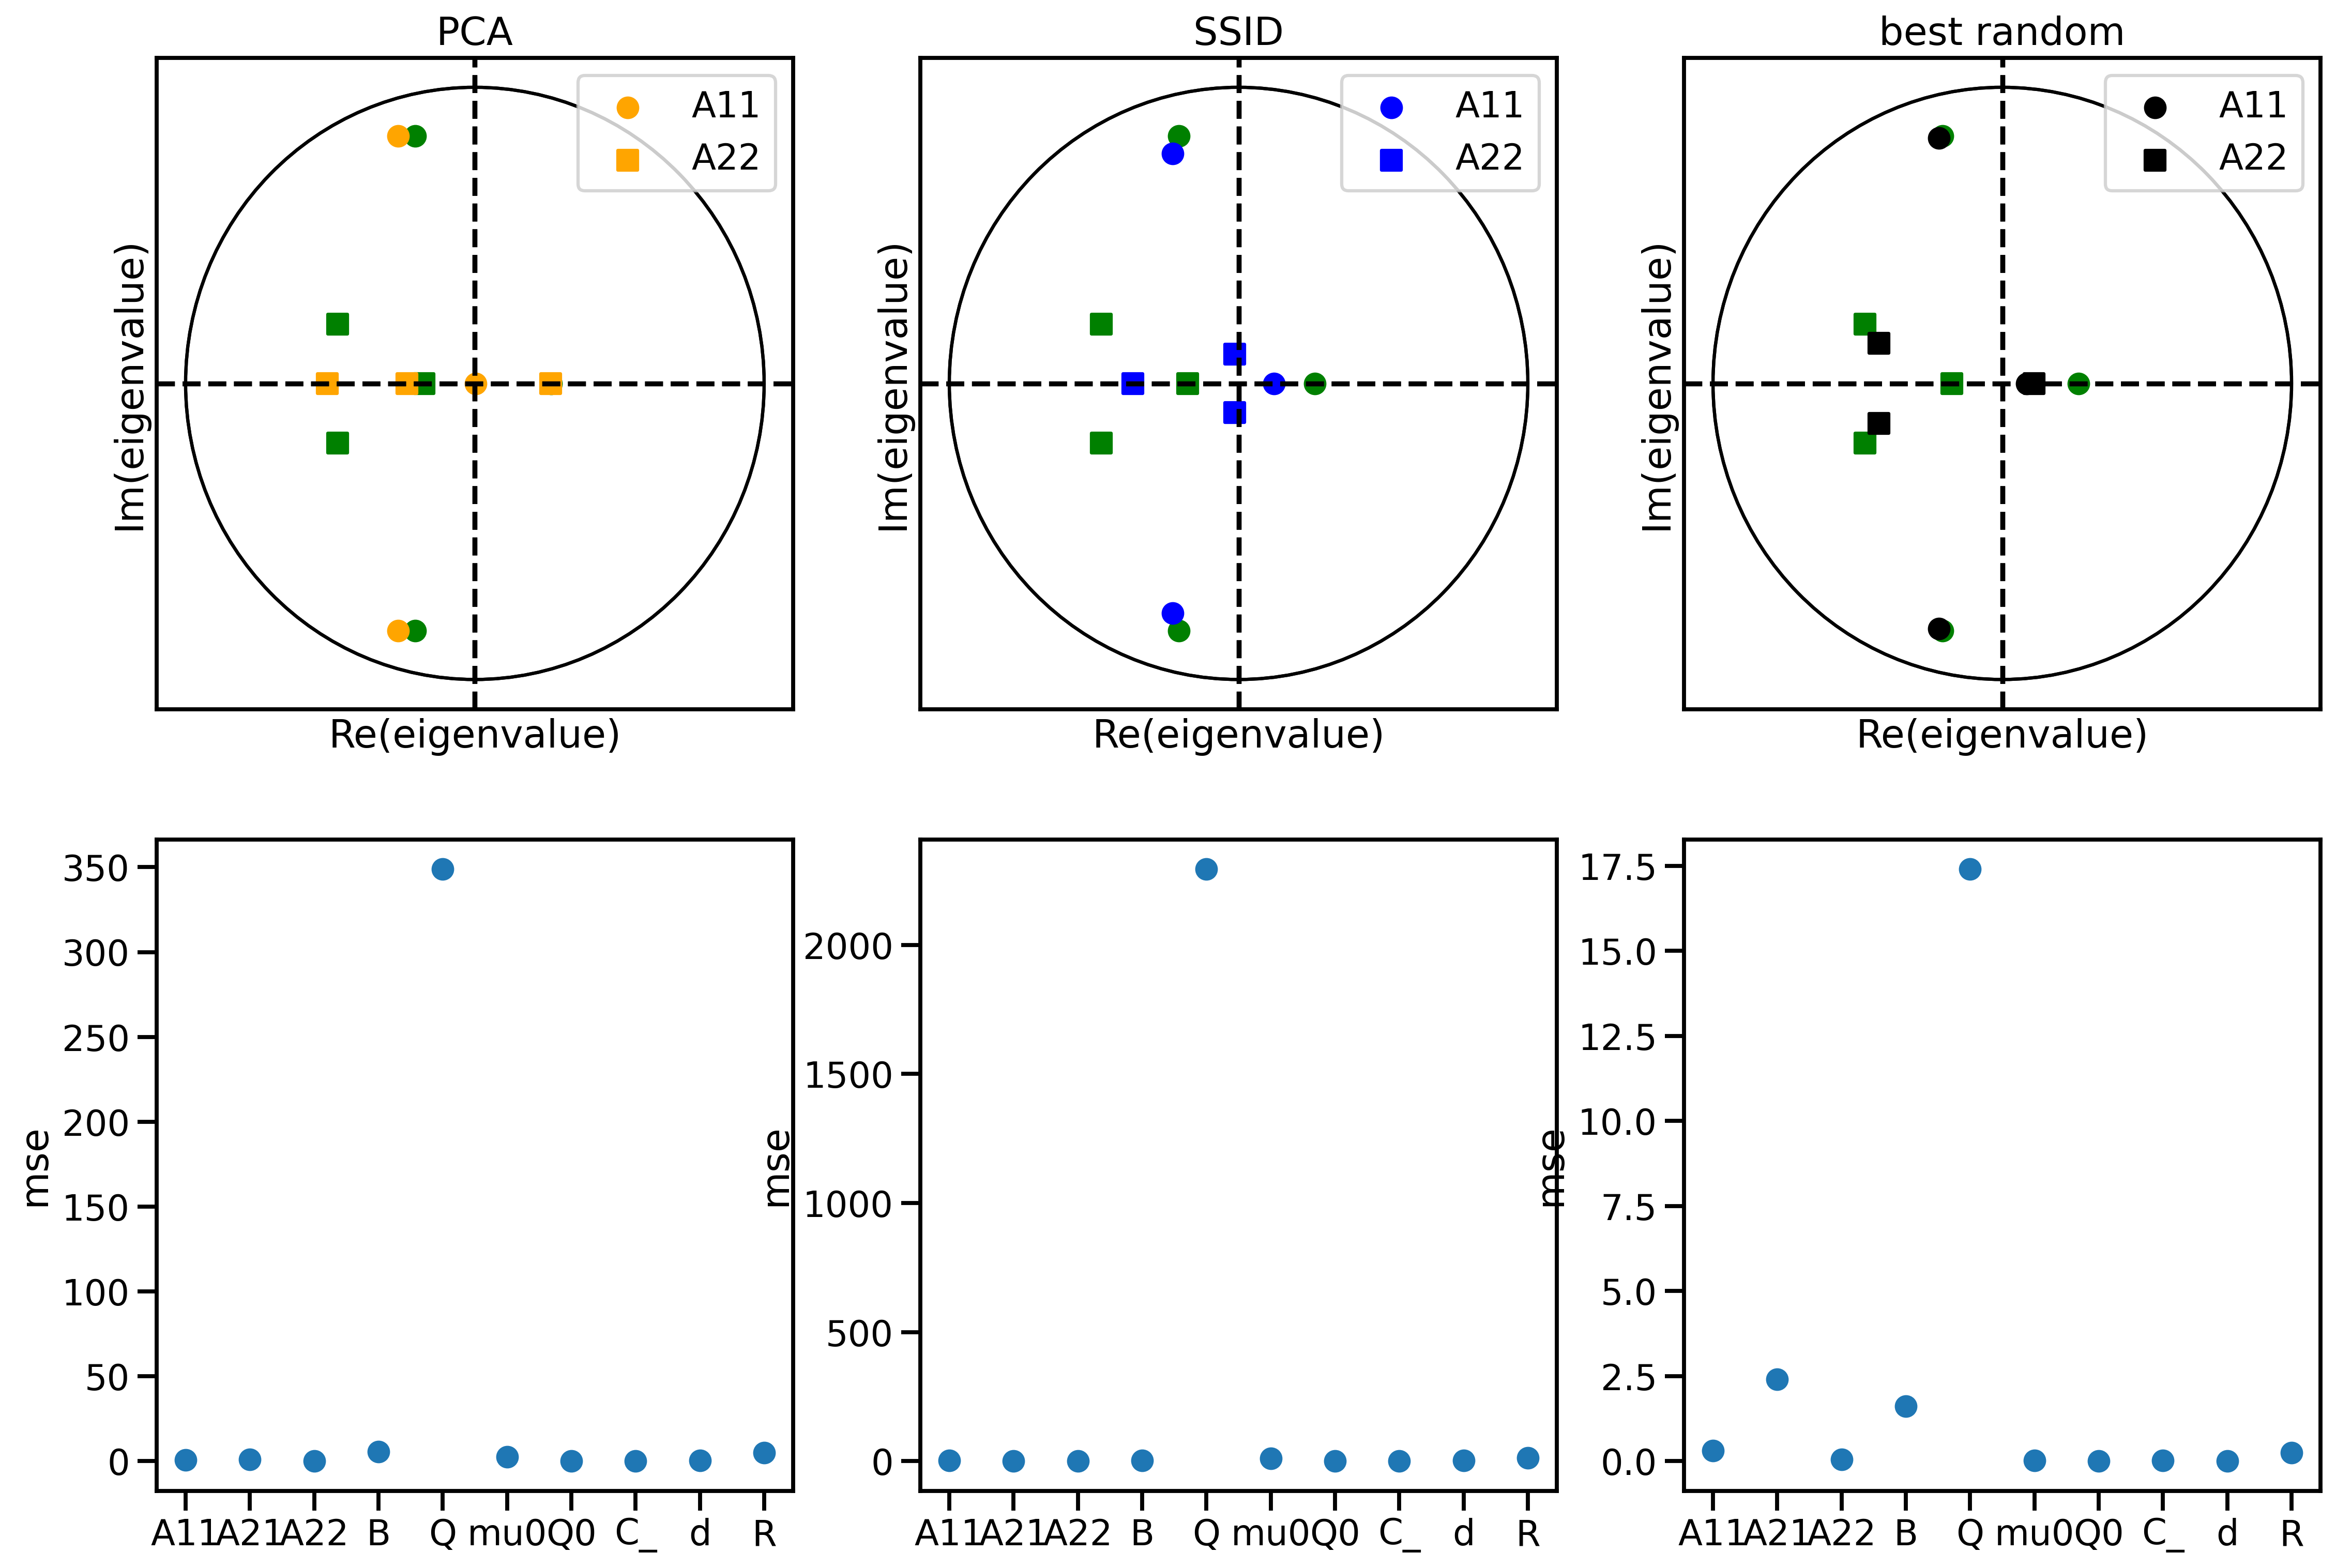

In [81]:
best_ind = np.argmax(elbos)+1


colors = ['green','orange','blue'] + ['black']

fig, axes = plt.subplots(2,3, dpi=300, figsize=(18,12))
ct = 1
for simulation in [1,2,best_ind]:
    fitted = np.load(f'models/K1={K1}_K2={K2}_fitted_param_simulation={simulation}.npz')
    A=fitted['A']
    B=fitted['B']
    Q=fitted['Q']
    mu0=fitted['mu0']
    Q0=fitted['Q0']
    C=fitted['C']
    d=fitted['d']
    R=fitted['R']
    plot_eigenvalues(axes[0,ct-1], np.linalg.eigvals(true_A[:K1,:K1]), np.linalg.eigvals(true_A[K1:,K1:]), color='green', alpha=1)
    plot_eigenvalues(axes[0,ct-1], np.linalg.eigvals(A[:K1,:K1]), np.linalg.eigvals(A[K1:,K1:]), color=colors[ct], alpha=1, label=['A11','A22'])
    axes[0,ct-1].set_xticks([])
    axes[0,ct-1].set_yticks([])
    axes[0,ct-1].set_title(label[ct])
    axes[0,ct-1].legend(loc='upper right')
    plot_mse_parameters(axes[1,ct-1], K1, A, B, Q, mu0, true_Q0, C, d, R, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R)

    ct+=1

